# **Prediction target:**
Multi-class classification across 7 different emotions from thouands of audio files from Ravdess and TESS datasets <br>
{neutral, happy, sad, angry, fear, disgust, surprise}


# **RNN**

In [ ]:
# === A. MOUNT DRIVE (once per session) ===
from google.colab import drive, auth
drive.mount('/content/drive', force_remount=False)

DRIVE_ROOT        = "/content/drive/MyDrive/multiclassproject"
RAVDESS_DIR_DRIVE = f"{DRIVE_ROOT}/Audio_Speech_Actors_01-24"
TESS_DIR_DRIVE    = f"{DRIVE_ROOT}/TESS Toronto emotional speech set data"



Mounted at /content/drive


In [ ]:
# === A. MOUNT DRIVE & DEFINE PATHS ===
from google.colab import drive
import os

# Mount Google Drive (if not already mounted)
if not os.path.ismount('/content/drive'):
    drive.mount('/content/drive', force_remount=False)

# --- Define paths for datasets in Google Drive ---
DRIVE_ROOT        = "/content/drive/MyDrive/multiclassproject"
RAVDESS_DIR_DRIVE = f"{DRIVE_ROOT}/Audio_Speech_Actors_01-24"
TESS_DIR_DRIVE    = f"{DRIVE_ROOT}/TESS Toronto emotional speech set data"

# --- Path to the compressed CREMA-D file in Drive ---
CREMA_TAR_DRIVE   = f"{DRIVE_ROOT}/CREMA-D.tar.gz"

# --- LOCAL path where CREMA-D will be extracted for FAST access ---
# The tar file contains a directory named 'AudioWAV'.
CREMA_DIR_LOCAL   = "/content/AudioWAV"

print("✅ Paths defined.")
print(f"RAVDESS (Drive): {RAVDESS_DIR_DRIVE}")
print(f"TESS (Drive):    {TESS_DIR_DRIVE}")
print(f"CREMA-D (TAR):   {CREMA_TAR_DRIVE}")


# === B. EXTRACT CREMA-D TO LOCAL DISK ===
# Check if the tar file exists before trying to extract
if os.path.exists(CREMA_TAR_DRIVE):
    print(f"\nFound '{os.path.basename(CREMA_TAR_DRIVE)}'.")
    print("Extracting to local Colab disk for faster processing...")

    # Use !tar to unzip the file directly into the /content/ directory
    !tar -xzf "{CREMA_TAR_DRIVE}" -C /content/

    print(f"✅ Extraction complete. CREMA-D data is ready at: {CREMA_DIR_LOCAL}")
else:
    print(f"❌ ERROR: The file was not found at {CREMA_TAR_DRIVE}")

✅ Paths defined.
RAVDESS (Drive): /content/drive/MyDrive/multiclassproject/Audio_Speech_Actors_01-24
TESS (Drive):    /content/drive/MyDrive/multiclassproject/TESS Toronto emotional speech set data
CREMA-D (TAR):   /content/drive/MyDrive/multiclassproject/CREMA-D.tar.gz

Found 'CREMA-D.tar.gz'.
Extracting to local Colab disk for faster processing...
✅ Extraction complete. CREMA-D data is ready at: /content/AudioWAV


In [ ]:
# === TO SPEED-UP PROCESSING (All datasets via rsync) ===
import os
import subprocess
import shlex

PROJECT_NAME = "speech_emotion_ravdess_tess_crema"
DATASET_NAME = "ravdess_tess_crema_7cls"

# ---------- Ensure Drive + define source folders ----------
def ensure_drive_paths():
    """Defines and validates the source directories in Google Drive."""
    global DRIVE_ROOT, RAVDESS_DIR_DRIVE, TESS_DIR_DRIVE, CREMA_DIR_DRIVE
    if not os.path.ismount("/content/drive"):
        from google.colab import drive
        drive.mount("/content/drive", force_remount=False)

    DRIVE_ROOT = "/content/drive/MyDrive/multiclassproject"
    RAVDESS_DIR_DRIVE = f"{DRIVE_ROOT}/Audio_Speech_Actors_01-24"
    TESS_DIR_DRIVE = f"{DRIVE_ROOT}/TESS Toronto emotional speech set data"
    # Path to the CREMA-D FOLDER in Drive, as seen in your screenshot
    CREMA_DIR_DRIVE = f"{DRIVE_ROOT}/crema"

    assert os.path.isdir(RAVDESS_DIR_DRIVE), f"Missing: {RAVDESS_DIR_DRIVE}"
    assert os.path.isdir(TESS_DIR_DRIVE), f"Missing: {TESS_DIR_DRIVE}"
    assert os.path.isdir(CREMA_DIR_DRIVE), f"Missing: {CREMA_DIR_DRIVE}"
    print("✅ All source directories found in Google Drive.")

ensure_drive_paths()

# ---------- Local workspace (FAST) ----------
LOCAL_ROOT = f"/content/data/{PROJECT_NAME}"
LOCAL_RAVDESS = f"{LOCAL_ROOT}/RAVDESS"
LOCAL_TESS = f"{LOCAL_ROOT}/TESS"
LOCAL_CREMA = f"{LOCAL_ROOT}/CREMA"  # Consistent local directory name
os.makedirs(LOCAL_RAVDESS, exist_ok=True)
os.makedirs(LOCAL_TESS, exist_ok=True)
os.makedirs(LOCAL_CREMA, exist_ok=True)

# --- knobs ---
FORCE_RESYNC = False

# ---------- helpers ----------
def _count_wavs(path: str) -> int:
    """Counts .wav files in a given directory path."""
    if not os.path.isdir(path):
        return 0
    try:
        out = subprocess.check_output(f'find "{path}" -type f -iname "*.wav" | wc -l', shell=True).decode().strip()
        return int(out or 0)
    except subprocess.CalledProcessError:
        return 0

def _mirror_rsync(src: str, dst: str, label: str):
    """Mirrors a source directory to a destination using rsync."""
    os.makedirs(dst, exist_ok=True)
    args = ['rsync', '-a', '--delete', '--info=progress2', src.rstrip('/') + '/', dst]
    print(f"[{label}] Mirroring Drive → Local (rsync)...")
    subprocess.run(args, check=True)

# ---------- main: ensure all local data is synced via rsync ----------
def ensure_local_data():
    """Checks if local data matches Drive and syncs if necessary."""
    print("--- Checking status of local dataset copies ---")
    # Get file counts from both Drive and local for all three datasets
    rav_drive_count = _count_wavs(RAVDESS_DIR_DRIVE)
    tess_drive_count = _count_wavs(TESS_DIR_DRIVE)
    crema_drive_count = _count_wavs(CREMA_DIR_DRIVE)

    rav_local_count = _count_wavs(LOCAL_RAVDESS)
    tess_local_count = _count_wavs(LOCAL_TESS)
    crema_local_count = _count_wavs(LOCAL_CREMA)

    # Check if any of the datasets are incomplete locally
    needs_sync = (
        FORCE_RESYNC or
        rav_local_count < rav_drive_count * 0.98 or
        tess_local_count < tess_drive_count * 0.98 or
        crema_local_count < crema_drive_count * 0.98
    )

    if needs_sync:
        print("One or more datasets are incomplete locally. Syncing all datasets...")
        _mirror_rsync(RAVDESS_DIR_DRIVE, LOCAL_RAVDESS, "RAVDESS")
        _mirror_rsync(TESS_DIR_DRIVE,    LOCAL_TESS,    "TESS")
        _mirror_rsync(CREMA_DIR_DRIVE,   LOCAL_CREMA,   "CREMA-D")
    else:
        print("✅ All dataset copies are up-to-date. Skipping sync.")

ensure_local_data()

# ---------- Use LOCAL paths from now on ----------
RAVDESS_DIR = LOCAL_RAVDESS
TESS_DIR = LOCAL_TESS
CREMA_DIR = LOCAL_CREMA

# ---------- Inventory (after sync) ----------
rav_count = _count_wavs(RAVDESS_DIR)
tess_count = _count_wavs(TESS_DIR)
crema_count = _count_wavs(CREMA_DIR)
print("\nREADY — working locally on the VM SSD")
print(f"RAVDESS local: {RAVDESS_DIR}  -> {rav_count} wavs")
print(f"TESS    local: {TESS_DIR}     -> {tess_count} wavs")
print(f"CREMA-D local: {CREMA_DIR}    -> {crema_count} wavs")

✅ All source directories found in Google Drive.
--- Checking status of local dataset copies ---
One or more datasets are incomplete locally. Syncing all datasets...
[RAVDESS] Mirroring Drive → Local (rsync)...
[TESS] Mirroring Drive → Local (rsync)...
[CREMA-D] Mirroring Drive → Local (rsync)...

READY — working locally on the VM SSD
RAVDESS local: /content/data/speech_emotion_ravdess_tess_crema/RAVDESS  -> 1440 wavs
TESS    local: /content/data/speech_emotion_ravdess_tess_crema/TESS     -> 2800 wavs
CREMA-D local: /content/data/speech_emotion_ravdess_tess_crema/CREMA    -> 7442 wavs


In [ ]:
# === 1. IMPORTS & CONFIG ===
import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
warnings.filterwarnings('ignore')

import librosa, librosa.display
from IPython.display import Audio
from tqdm import tqdm
import os,glob,re,random


**Initial cleaning of the dataset format**

1.   Lowercasing all labels

  *   Example:Ensures "Happy" and "happy" are treated the same
  *   This removes differences caused by inconsistent capital letters

2.   Removing all leading/trailing spaces

  *   Removes extra spaces "happy_" with a space to avoid being counted as a separate label from "happy"

3.   Normalization of common variations

  *   Example:converting "pleasant_surprise" to "ps" so we can see it as the same shorthand form used in other files.
  *   This is still not mapping to "surprise" yet — just making the form consistent.

**Outcome:**
  *   This step usually reduces the number of unique labels (because duplicates collapse).
  *   It makes the set difference check between datasets more accurate — now it highlights real mismatches instead of superficial ones.


In [ ]:
# === 1A. RAW INSPECTION (Corrected for nested CREMA-D) ===
import pandas as pd
import os

# Assumes RAVDESS_DIR, TESS_DIR, and CREMA_DIR are already defined from the previous cell

# --- PATH CORRECTION for CREMA-D ---
# As shown in your screenshot, the .wav files are inside an 'AudioWAV' subfolder.
# We'll create a new variable that points directly to it.
CREMA_AUDIO_DIR = os.path.join(CREMA_DIR, "AudioWAV")
print(f"Corrected path for CREMA-D audio: {CREMA_AUDIO_DIR}")


def sample_files(root, n=8):
    out = []
    for d,_,files in os.walk(root):
        for fn in files:
            if fn.lower().endswith(".wav"):
                out.append(os.path.join(d, fn))
                if len(out) >= n:
                    return out
    return out

print("\nSample RAVDESS files:")
for p in sample_files(RAVDESS_DIR): print("  ", os.path.basename(p))

print("\nSample TESS files:")
for p in sample_files(TESS_DIR): print("  ", os.path.basename(p))

# Use the corrected path to sample files
print("\nSample CREMA-D files:")
for p in sample_files(CREMA_AUDIO_DIR): print("  ", os.path.basename(p))


# --- Extract RAW labels straight from filenames (dataset-native) ---
RAVDESS_EMOTION_CODEBOOK = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fear', '07': 'disgust', '08': 'surprise'
}

def ravdess_raw_labels(ravdess_dir):
    rows = []
    for d,_,files in os.walk(ravdess_dir):
        for fn in files:
            if not fn.lower().endswith(".wav"): continue
            parts = fn.split('-')
            label = RAVDESS_EMOTION_CODEBOOK.get(parts[2]) if len(parts) > 2 else None
            rows.append({"dataset":"RAVDESS","path":os.path.join(d,fn),"raw_label":label,"file":fn})
    return pd.DataFrame(rows)

def tess_raw_labels(tess_dir):
    rows = []
    for d,_,files in os.walk(tess_dir):
        for fn in files:
            if not fn.lower().endswith(".wav"): continue
            emotion = fn.split('_')[-1].split('.')[0] if '_' in fn else None
            rows.append({"dataset":"TESS","path":os.path.join(d,fn),"raw_label":emotion,"file":fn})
    return pd.DataFrame(rows)

# MODIFIED to handle the nested 'AudioWAV' folder
def crema_raw_labels(crema_audio_dir):
    rows = []
    # Use os.walk to robustly find files in subdirectories
    for d, _, files in os.walk(crema_audio_dir):
        for fn in files:
            if not fn.lower().endswith(".wav"): continue
            # Filename: 1001_DFA_ANG_XX.wav -> Emotion is the 3rd part
            parts = fn.split('_')
            label = parts[2] if len(parts) > 2 else None
            rows.append({"dataset":"CREMA-D", "path":os.path.join(d, fn), "raw_label":label, "file":fn})
    return pd.DataFrame(rows)


rav_raw = ravdess_raw_labels(RAVDESS_DIR)
tes_raw = tess_raw_labels(TESS_DIR)
# Call the function with the corrected path
crema_raw = crema_raw_labels(CREMA_AUDIO_DIR)

raw_df = pd.concat([rav_raw, tes_raw, crema_raw], ignore_index=True)

print("\n--- Distinct RAW labels per dataset (BEFORE any cleaning/mapping) ---")
for name, sub in raw_df.groupby("dataset"):
    print(f"\n{name}:")
    print(sub["raw_label"].value_counts(dropna=False).sort_index())

print("\n--- Quick mismatch check (RAW) ---")
rav_set_raw = set(rav_raw["raw_label"].dropna().unique())
tes_set_raw = set(tes_raw["raw_label"].dropna().unique())
crema_set_raw = set(crema_raw["raw_label"].dropna().unique())

print("RAVDESS raw set:", sorted(rav_set_raw))
print("TESS    raw set:", sorted(tes_set_raw))
print("CREMA-D raw set:", sorted(crema_set_raw))
print("\n--- Differences ---")
print("Only-in-RAVDESS (vs all):", sorted(rav_set_raw - tes_set_raw - crema_set_raw))
print("Only-in-TESS    (vs all):", sorted(tes_set_raw - rav_set_raw - crema_set_raw))
print("Only-in-CREMA-D (vs all):", sorted(crema_set_raw - rav_set_raw - tes_set_raw))

Corrected path for CREMA-D audio: /content/data/speech_emotion_ravdess_tess_crema/CREMA/AudioWAV

Sample RAVDESS files:
   03-01-08-01-01-02-19.wav
   03-01-03-01-02-01-19.wav
   03-01-08-02-02-01-19.wav
   03-01-03-02-02-01-19.wav
   03-01-06-01-02-01-19.wav
   03-01-04-02-02-01-19.wav
   03-01-08-01-02-01-19.wav
   03-01-07-02-02-01-19.wav

Sample TESS files:
   YAF_sour_ps.wav
   YAF_deep_ps.wav
   YAF_tire_ps.wav
   YAF_mop_ps.wav
   YAF_rot_ps.wav
   YAF_long_ps.wav
   YAF_said_ps.wav
   YAF_nag_ps.wav

Sample CREMA-D files:
   1084_ITS_SAD_XX.wav
   1069_IEO_HAP_HI.wav
   1089_DFA_ANG_XX.wav
   1022_IEO_FEA_MD.wav
   1046_DFA_ANG_XX.wav
   1024_IEO_FEA_HI.wav
   1091_TIE_DIS_XX.wav
   1019_TSI_FEA_XX.wav

--- Distinct RAW labels per dataset (BEFORE any cleaning/mapping) ---

CREMA-D:
raw_label
ANG    1271
DIS    1271
FEA    1271
HAP    1271
NEU    1087
SAD    1271
Name: count, dtype: int64

RAVDESS:
raw_label
angry       192
calm        192
disgust     192
fear        192
happy  

In [ ]:
# === 1B. LIGHT CLEANING —  ===
# Objective: show how simple normalization changes the comparison

def normalize_for_display(s):
    return (
        s.astype(str)          # handle None/NaN uniformly
         .str.strip()
         .str.lower()
         .str.replace('pleasant_surprise', 'ps', regex=False)  # optional: unify common variations
    )

clean_df = raw_df.copy()
clean_df["raw_label_clean"] = normalize_for_display(clean_df["raw_label"])

print("\n--- Distinct labels after LIGHT CLEAN (lowercase/strip only) ---")
# This loop already works for all datasets, including CREMA-D
for name, sub in clean_df.groupby("dataset"):
    print(f"\n{name} (clean view):")
    print(sub["raw_label_clean"].value_counts(dropna=False).sort_index())

# --- MODIFIED FOR 3-WAY COMPARISON ---
print("\n--- Quick mismatch check (CLEAN VIEW) ---")
rav_set_clean = set(clean_df.loc[clean_df.dataset=="RAVDESS","raw_label_clean"].dropna().unique())
tes_set_clean = set(clean_df.loc[clean_df.dataset=="TESS","raw_label_clean"].dropna().unique())
# ADDED FOR CREMA-D
crema_set_clean = set(clean_df.loc[clean_df.dataset=="CREMA-D","raw_label_clean"].dropna().unique())

print("RAVDESS clean set:", sorted(rav_set_clean))
print("TESS    clean set:", sorted(tes_set_clean))
print("CREMA-D clean set:", sorted(crema_set_clean)) # ADDED FOR CREMA-D
print("\n--- Differences (CLEAN VIEW) ---")
print("Only-in-RAVDESS (vs all):", sorted(rav_set_clean - tes_set_clean - crema_set_clean))
print("Only-in-TESS    (vs all):", sorted(tes_set_clean - rav_set_clean - crema_set_clean))
print("Only-in-CREMA-D (vs all):", sorted(crema_set_clean - rav_set_clean - tes_set_clean))


--- Distinct labels after LIGHT CLEAN (lowercase/strip only) ---

CREMA-D (clean view):
raw_label_clean
ang    1271
dis    1271
fea    1271
hap    1271
neu    1087
sad    1271
Name: count, dtype: int64

RAVDESS (clean view):
raw_label_clean
angry       192
calm        192
disgust     192
fear        192
happy       192
neutral      96
sad         192
surprise    192
Name: count, dtype: int64

TESS (clean view):
raw_label_clean
angry      400
disgust    400
fear       400
happy      400
neutral    400
ps         400
sad        400
Name: count, dtype: int64

--- Quick mismatch check (CLEAN VIEW) ---
RAVDESS clean set: ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
TESS    clean set: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad']
CREMA-D clean set: ['ang', 'dis', 'fea', 'hap', 'neu', 'sad']

--- Differences (CLEAN VIEW) ---
Only-in-RAVDESS (vs all): ['calm', 'surprise']
Only-in-TESS    (vs all): ['ps']
Only-in-CREMA-D (vs all): ['ang', 'dis', '

**Mapping of filenames on the dataset to native labels.** <br>

This step converts the raw labels from each dataset's filenames into a standardized set of emotion words. The process differs per dataset.

 decodes RAVDESS emotion codes into words using the codebook. <br>

*   For RAVDESS: Decodes numeric emotion codes (e.g., '03') into full words ('happy') using its specific codebook.
  > RAVDESS_EMOTION_CODEBOOK = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fear', '07': 'disgust', '08': 'surprise'
}
*   For TESS dataset, extracts the word (e.g., happy, ps) directly from the end of the filename.

*   For CREMA-D: Similarly, decodes three-letter abbreviations (e.g., 'HAP') into full words ('happy') using the CREMA-D codebook.

*   For all datasets: The final label_mapped is created by converting the resulting word to lowercase and stripping any extra spaces to ensure consistency across the entire collection.


In [ ]:
# === DATA LOADING — DATASET-NATIVE MAPPING ===


# --- Path Correction for CREMA-D ---
# Ensure we are pointing to the correct subdirectory containing the audio files.
CREMA_AUDIO_DIR = os.path.join(CREMA_DIR, "AudioWAV")


RAVDESS_EMOTION_CODEBOOK = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fear', '07': 'disgust', '08': 'surprise'
}

# ADDED FOR CREMA-D: Maps 3-letter code to the emotion word.
CREMA_EMOTION_CODEBOOK = {
    'ANG': 'angry',
    'DIS': 'disgust',
    'FEA': 'fear',
    'HAP': 'happy',
    'NEU': 'neutral',
    'SAD': 'sad'
}

def load_ravdess_native(ravdess_dir):
    paths, raw = [], []
    for dirname, _, files in os.walk(ravdess_dir):
        for fn in files:
            if not fn.lower().endswith(".wav"):
                continue
            parts = fn.split('-')
            label = RAVDESS_EMOTION_CODEBOOK.get(parts[2]) if len(parts) > 2 else None
            paths.append(os.path.join(dirname, fn))
            raw.append(label)
    df = pd.DataFrame({"dataset":"RAVDESS","path":paths,"label_raw":raw})
    df["label_mapped"] = df["label_raw"].astype(str).str.strip().str.lower()
    return df

def load_tess_native(tess_dir):
    paths, raw = [], []
    for dirname, _, files in os.walk(tess_dir):
        for fn in files:
            if not fn.lower().endswith(".wav"):
                continue
            token = fn.split('_')[-1].split('.')[0] if '_' in fn else None
            paths.append(os.path.join(dirname, fn))
            raw.append(token)
    df = pd.DataFrame({"dataset":"TESS","path":paths,"label_raw":raw})
    df["label_mapped"] = df["label_raw"].astype(str).str.strip().str.lower()
    return df

# ADDED FOR CREMA-D
def load_crema_native(crema_audio_dir):
    paths, raw = [], []
    for dirname, _, files in os.walk(crema_audio_dir):
        for fn in files:
            if not fn.lower().endswith(".wav"):
                continue
            # Filename: 1001_DFA_ANG_XX.wav -> Emotion code is the 3rd part
            parts = fn.split('_')
            code = parts[2] if len(parts) > 2 else None
            label = CREMA_EMOTION_CODEBOOK.get(code) # Use the codebook to get the full word
            paths.append(os.path.join(dirname, fn))
            raw.append(label) # label_raw will be 'angry', 'sad', etc.
    df = pd.DataFrame({"dataset":"CREMA-D","path":paths,"label_raw":raw})
    df["label_mapped"] = df["label_raw"].astype(str).str.strip().str.lower()
    return df

rav_native = load_ravdess_native(RAVDESS_DIR)
tess_native = load_tess_native(TESS_DIR)
crema_native = load_crema_native(CREMA_AUDIO_DIR) # ADDED

# MODIFIED to include CREMA-D
native_df = pd.concat([rav_native, tess_native, crema_native], ignore_index=True)

print("--- Dataset-native labels (label_mapped) ---")
for name, sub in native_df.groupby("dataset"):
    print(f"\n{name} counts:")
    print(sub["label_mapped"].value_counts(dropna=False).sort_index())

--- Dataset-native labels (label_mapped) ---

CREMA-D counts:
label_mapped
angry      1271
disgust    1271
fear       1271
happy      1271
neutral    1087
sad        1271
Name: count, dtype: int64

RAVDESS counts:
label_mapped
angry       192
calm        192
disgust     192
fear        192
happy       192
neutral      96
sad         192
surprise    192
Name: count, dtype: int64

TESS counts:
label_mapped
angry      400
disgust    400
fear       400
happy      400
neutral    400
ps         400
sad        400
Name: count, dtype: int64


**Merging of all datasets into a  7-class emotion category** <br>
Objective: convert both datasets’ labels to the same final vocabulary for training.

*   calm → neutral
*   fearful → fear
*   ps or pleasant_surprise → surprise
*   also ensure all lowercased


In [ ]:
# === HARMONIZATION — map dataset-native labels to final taxonomy ===

FINAL_TAXONOMY = ['neutral','happy','sad','angry','fear','disgust','surprise']

HARMONIZE_MAP = {
    # normalize synonyms/variants
    'fearful': 'fear',
    'pleasant_surprise': 'surprise',
    'ps': 'surprise',
    # merge categories as decided
    'calm': 'neutral',
}

def harmonize_labels(df):
    out = df.copy()
    # start from label_mapped (already lowercase/strip)
    out["label_final"] = out["label_mapped"].replace(HARMONIZE_MAP)
    # keep everything lowercase just in case
    out["label_final"] = out["label_final"].astype(str).str.strip().str.lower()
    return out

harm_df = harmonize_labels(native_df)

print("\n--- 2B: Harmonized labels (label_final) ---")
for name, sub in harm_df.groupby("dataset"):
    print(f"\n{name} counts:")
    print(sub["label_final"].value_counts(dropna=False).sort_index())



--- 2B: Harmonized labels (label_final) ---

CREMA-D counts:
label_final
angry      1271
disgust    1271
fear       1271
happy      1271
neutral    1087
sad        1271
Name: count, dtype: int64

RAVDESS counts:
label_final
angry       192
disgust     192
fear        192
happy       192
neutral     288
sad         192
surprise    192
Name: count, dtype: int64

TESS counts:
label_final
angry       400
disgust     400
fear        400
happy       400
neutral     400
sad         400
surprise    400
Name: count, dtype: int64


# Merging of labels and emotions for both datasets

In [ ]:
# === VALIDATION & FILTERING TO FINAL TAXONOMY ===

def filter_to_final_taxonomy(df, allowed=FINAL_TAXONOMY):
    before = len(df)
    keep_mask = df["label_final"].isin(allowed)
    dropped = (~keep_mask).sum()
    filtered = df[keep_mask].reset_index(drop=True)
    print(f"\nKept {len(filtered)}/{before} files. Dropped {dropped} not in final taxonomy.")
    print("Final label set:", sorted(filtered["label_final"].unique()))
    return filtered

df = filter_to_final_taxonomy(harm_df)

# (Optional) tidy columns for modeling
df = df[["path","label_final"]].rename(columns={"label_final":"label"})

print("\nTotal files for training:", len(df))
print("Labels:", sorted(df['label'].unique()))
df.head()



Kept 11682/11682 files. Dropped 0 not in final taxonomy.
Final label set: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Total files for training: 11682
Labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


,path,label
0,/content/data/speech_emotion_ravdess_tess_crem...,surprise
1,/content/data/speech_emotion_ravdess_tess_crem...,happy
2,/content/data/speech_emotion_ravdess_tess_crem...,surprise
3,/content/data/speech_emotion_ravdess_tess_crem...,happy
4,/content/data/speech_emotion_ravdess_tess_crem...,fear


# Second set of Data format cleaning

*   Remove missing paths or labels (dropna)
*   Remove duplicate file entries
  * This step prevents errors during model training and guarantees that each row corresponds to a valid, unique audio file with a clean label
*   Keep only files that still exist on disk (os.path.exists)
  * We checked that each path actually points to an existing .wav file.





In [ ]:
# === DATASET CLEANING ===
# Drop rows with missing path/label
df = df.dropna(subset=['path','label']).copy()

# Keep only files that actually exist
df = df[df['path'].apply(os.path.exists)].reset_index(drop=True)

# Drop duplicate file paths (safety)
df = df.drop_duplicates(subset=['path']).reset_index(drop=True)

print("After basic cleaning:", df.shape)


After basic cleaning: (11682, 2)


**Audio File Diagnostics**
The purpose of this script is to analyze the technical properties of a single audio file. It identifies potential quality issues and generates a report with specific recommendations for preprocessing steps. The process is handled by three main functions:


*   dataset_profile(path): This function first identifies the source dataset (TESS, RAVDESS, or CREMA-D) by inspecting the input file path. It then returns a profile containing standard parameters for that dataset, such as the target sample rate (e.g., 22050 Hz) and an expected duration range.
*   audio_stats(...): This function takes the raw audio data and calculates a dictionary of key technical metrics. These metrics include the sample rate, duration, peak amplitude, RMS (Root Mean Square) level for loudness, mean amplitude (to check for DC offset), and the amount of leading/trailing silence.
*   print_stats(...): It compares the actual metrics calculated by audio_stats against the standard parameters defined in dataset_profile. Based on this comparison, it prints a summary with explicit recommendations for cleaning actions, such as whether to resample, normalize, or trim the audio file.









STEP 2 — DIAGNOSTICS ON SAMPLE DATA
File: /content/drive/MyDrive/multiclassproject/TESS Toronto emotional speech set data/OAF_angry/OAF_voice_angry.wav

BEFORE CLEANING (RAW)
Sample rate (Hz)         : 24414 → resample to 22050 Hz for TESS consistency.


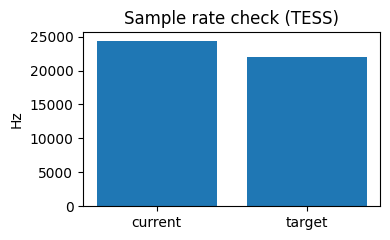

Duration (sec)           : 1.589 → OK (within typical TESS range 1.20–2.50s).
Peak amplitude           : 0.1522 → quiet; normalize up to target peak ≈ 0.95.
RMS (dB)                 : -31.20 → very quiet; gain-up likely needed.
Mean amplitude           : -0.0000 → centered near zero.
Leading silence (ms)     : 62 → trim recommended.
Trailing silence (ms)    : 246 → trim recommended.
Clipping (%)             : 0.000 → low.


In [ ]:
# ---- plain text step header (no borders, no colors)
def print_step_header(step_number, description):
    print(f"STEP {step_number} — {description}")

# === STEP 2 ===
print_step_header(2, "DIAGNOSTICS ON SAMPLE DATA")

# ---- dataset-aware profile (targets & typical duration ranges) ----
def dataset_profile(path):
    p = path.lower()
    # Defaults if unknown
    profile = {
        "name": "dataset",
        "target_sr": 22050,
        "dur_range": (1.0, 4.0)  # seconds
    }
    if "tess" in p:
        profile.update({"name": "TESS", "target_sr": 22050, "dur_range": (1.2, 2.5)})
    elif "ravdess" in p or "actor_" in p:
        profile.update({"name": "RAVDESS", "target_sr": 22050, "dur_range": (2.5, 4.0)})
    # ADDED FOR CREMA-D
    elif "crema" in p:
        profile.update({"name": "CREMA-D", "target_sr": 22050, "dur_range": (1.5, 3.5)})
    return profile

def audio_stats(y, sr, trim_db=20):
    """Diagnostics only — no cleaning applied."""
    y_mono = librosa.to_mono(y) if y.ndim == 2 else y
    dur = len(y_mono) / sr if sr else 0.0
    peak = float(np.max(np.abs(y_mono))) if y_mono.size else 0.0
    mean_amp = float(np.mean(y_mono)) if y_mono.size else 0.0
    rms = float(np.sqrt(np.mean(y_mono**2))) if y_mono.size else 0.0
    rms_db = 20 * np.log10(rms + 1e-12)
    _, idx = librosa.effects.trim(y_mono, top_db=trim_db)
    lead_ms = (idx[0] / sr) * 1000
    trail_ms = ((len(y_mono) - idx[1]) / sr) * 1000
    clip_pct = 100.0 * float(np.mean(np.abs(y_mono) >= 0.999)) if y_mono.size else 0.0
    return {
        "Sample rate (Hz)": sr, "Duration (sec)": round(dur, 3),
        "Peak amplitude": round(peak, 4), "RMS (dB)": round(rms_db, 2),
        "Mean amplitude": round(mean_amp, 4), "Leading silence (ms)": int(lead_ms),
        "Trailing silence (ms)": int(trail_ms), "Clipping (%)": round(clip_pct, 3),
        "_y": y_mono, "_sr": sr
    }

def inspect_raw(path, trim_db=20):
    """Load file as-is and return diagnostics."""
    y, sr = librosa.load(path, sr=None, mono=False)
    return audio_stats(y, sr, trim_db=trim_db)

# --- helper: conditional figures ---
def _plot_sr_if_needed(sr, target_sr, title_suffix=""):
    if sr == target_sr: return
    plt.figure(figsize=(4, 2.5)); plt.bar(["current", "target"], [sr, target_sr])
    plt.title(f"Sample rate check {title_suffix}"); plt.ylabel("Hz")
    plt.tight_layout(); plt.show()

def _plot_duration_if_outside(dur, lo, hi, title_suffix=""):
    if lo <= dur <= hi: return
    plt.figure(figsize=(5.5, 2.5)); plt.bar(["duration"], [dur])
    plt.hlines([lo, hi], xmin=-0.5, xmax=0.5, linestyles=["dashed","dashed"])
    plt.text(0.55, lo, f"lo={lo:.2f}s", va="center"); plt.text(0.55, hi, f"hi={hi:.2f}s", va="center")
    plt.title(f"Duration vs typical range {title_suffix}"); plt.ylabel("seconds")
    plt.tight_layout(); plt.show()

def print_stats(stats_dict, title="Diagnostics", path_for_context=None):
    prof = dataset_profile(path_for_context or "")
    sr, dur, peak, rmsdb, mean, lead, trail, clip = (
        stats_dict["Sample rate (Hz)"], stats_dict["Duration (sec)"],
        stats_dict["Peak amplitude"], stats_dict["RMS (dB)"],
        stats_dict["Mean amplitude"], stats_dict["Leading silence (ms)"],
        stats_dict["Trailing silence (ms)"], stats_dict["Clipping (%)"]
    )
    print("\n" + title)
    need = f"→ resample to {prof['target_sr']} Hz for {prof['name']} consistency." if sr != prof['target_sr'] else "→ OK (matches target)."
    print(f"{'Sample rate (Hz)':<25}: {sr} {need}")
    _plot_sr_if_needed(sr, prof['target_sr'], title_suffix=f"({prof['name']})")
    lo, hi = prof["dur_range"]
    if dur < lo: dmsg = f"→ shorter than typical {prof['name']} range {lo:.2f}–{hi:.2f}s."
    elif dur > hi: dmsg = f"→ longer than typical {prof['name']} range {lo:.2f}–{hi:.2f}s."
    else: dmsg = f"→ OK (within typical {prof['name']} range {lo:.2f}–{hi:.2f}s)."
    print(f"{'Duration (sec)':<25}: {dur:.3f} {dmsg}")
    _plot_duration_if_outside(dur, lo, hi, title_suffix=f"({prof['name']})")
    if peak >= 0.99 or clip > 0.1: pmsg = "→ TOO HOT / likely clipping; normalize down or limit."
    elif peak <= 0.65: pmsg = "→ quiet; normalize up to target peak ≈ 0.95."
    else: pmsg = "→ reasonable; normalization optional."
    print(f"{'Peak amplitude':<25}: {peak:.4f} {pmsg}")
    if rmsdb < -30: rmsg = "→ very quiet; gain-up likely needed."
    elif rmsdb > -12: rmsg = "→ loud; verify no distortion."
    else: rmsg = "→ typical dialog range."
    print(f"{'RMS (dB)':<25}: {rmsdb:.2f} {rmsg}")
    if abs(mean) > 0.02: mmsg = "→ DC offset suspected; apply high-pass/DC removal."
    else: mmsg = "→ centered near zero."
    print(f"{'Mean amplitude':<25}: {mean:.4f} {mmsg}")
    s_thresh = 50  # ms
    lmsg = "→ trim recommended." if lead > s_thresh else "→ minimal."
    tmsg = "→ trim recommended." if trail > s_thresh else "→ minimal."
    print(f"{'Leading silence (ms)':<25}: {lead} {lmsg}")
    print(f"{'Trailing silence (ms)':<25}: {trail} {tmsg}")
    cmsg = "→ high; review peaks or re-record." if clip > 0.1 else "→ low."
    print(f"{'Clipping (%)':<25}: {clip:.3f} {cmsg}")

# ----- DEMO on one fixed file -----
# This path is unchanged, as you requested.
example_path = "/content/drive/MyDrive/multiclassproject/TESS Toronto emotional speech set data/OAF_angry/OAF_voice_angry.wav"

# Safety check
import os
assert os.path.exists(example_path), f"File not found: {example_path}"

# Run diagnostics
raw_stats = inspect_raw(example_path, trim_db=20)
print(f"File: {example_path}")
print_stats(raw_stats, title="BEFORE CLEANING (RAW)", path_for_context=example_path)

<H1>EXPLANATION OF RESULTS</H1>

**Duration (sec): 1.589** – The clip length is within the typical TESS dataset range of 1.20–2.50 seconds, so no trimming or padding is necessary.
---
**Peak amplitude: 0.1522** – The loudest point in the audio reaches about 15.2% of the maximum possible digital amplitude, which is quiet. It can be normalized up to a target peak of around 0.95 to increase volume without distortion.
---
<b>RMS (dB): -31.20 dB </b>– This is the average loudness level of the clip. It is quieter than the typical dialog range (around -30 to -12 dB), so a gain boost will help for better audibility.
---
<b>Mean amplitude: -0.0000 </b>– The average amplitude across the clip is  zero, indicating no DC offset and a waveform centered properly.
---
**Leading silence (ms): 62 ms** – A short pause exists at the start of the clip. Trimming can help align data for more consistent processing and training.
---
**Trailing silence (ms): 246 ms** – There’s a longer pause at the end of the clip. Trimming is recommended to remove unnecessary silence that does not contribute to the signal.
---
<b>Clipping (%): 0.000</b> – No samples exceed the maximum amplitude, so there’s no distortion from clipping.
--



# **Which files needed cleaning for the entire dataset?**

<h2>THRESHOLDS</h2>
<p><b>TARGET_SR = 22050</b></p>
A common speech/audio standard in librosa tutorials. It halves 44.1k/48k audio while keeping energy up to ~11 kHz (speech is mostly <8 kHz). It makes TESS (≈24.4k) and RAVDESS (48k) consistent and cheaper to process.

<p><b>TRIM_DB = 20</p></b>
Used by librosa.effects.trim as “keep anything within 20 dB of the peak.” It’s a conservative silence trim that won’t chop quiet consonants/breaths. (30 dB is more aggressive; 10 dB is gentler.)

<p><b>PEAK_MIN_FOR_OK = 0.90</p></b>
If the file’s peak amplitude is <0.9 (on the -1..1 scale), we normalize. It’s a simple trigger to get peaks close to full scale without overreacting to tiny headroom differences.

<p><b>ABS_MEAN_MAX_OK = 0.01</p></b>
DC-offset check. |mean| > 0.01 (≈ -40 dB) is a noticeable bias; we recentre. Smaller offsets are usually negligible.

<p><b>SILENCE_MS_OK = 100</p></b>
If leading or trailing silence >100 ms, we trim. ~0.1 s is audible dead air but short enough to keep natural pauses.

<p><b>CLIP_PCT_OK = 0.1</p></b>
If ≥0.1% of samples hit |x|≥0.999, we flag clipping (saturation risk). Anything non-zero is suspicious; 0.1% avoids false positives from single spikes.

<p><b> DUR_RANGE_OK = (1.0, 4.0)</p></b>
Typical utterance length in TESS/RAVDESS sits ~1–3 s. Using 1–4 s catches outliers (too short/long) without being harsh.

In [ ]:
# --- config (thresholds) ---
TARGET_SR = 22050
TRIM_DB   = 20
PEAK_MIN_FOR_OK = 0.90
ABS_MEAN_MAX_OK = 0.01
SILENCE_MS_OK   = 100
CLIP_PCT_OK     = 0.1
DUR_RANGE_OK    = (1.0, 4.0)


# ---- Minimal audio processing functions ----
def _audio_stats_min(y, sr, trim_db=TRIM_DB):
    y_mono = librosa.to_mono(y) if y.ndim == 2 else y
    dur = len(y_mono)/sr if sr else 0.0
    peak = float(np.max(np.abs(y_mono))) if y_mono.size else 0.0
    mean_amp = float(np.mean(y_mono)) if y_mono.size else 0.0
    rms = float(np.sqrt(np.mean(y_mono**2))) if y_mono.size else 0.0
    rms_db = 20*np.log10(rms + 1e-12)
    _, idx = librosa.effects.trim(y_mono, top_db=trim_db)
    lead_ms  = (idx[0] / sr) * 1000
    trail_ms = ((len(y_mono) - idx[1]) / sr) * 1000
    clip_pct = 100.0 * float(np.mean(np.abs(y_mono) >= 0.999)) if y_mono.size else 0.0
    return {
        "sr": sr, "duration_sec": round(dur,3), "peak_amp": round(peak,4),
        "rms_db": round(rms_db,2), "mean_amp": round(mean_amp,4),
        "leading_silence_ms": int(lead_ms), "trailing_silence_ms": int(trail_ms),
        "clipping_pct": round(clip_pct,3)
    }

def audio_stats(y, sr, trim_db=TRIM_DB):
    return _audio_stats_min(y, sr, trim_db)

def inspect_raw(path, trim_db=TRIM_DB):
    y, sr = librosa.load(path, sr=None, mono=False)
    return audio_stats(y, sr, trim_db=trim_db)

# ---- Build manifest if missing ----

# --- Define paths and codebooks needed to build the manifest ---
CREMA_AUDIO_DIR = os.path.join(CREMA_DIR, "AudioWAV")
TESS_EMOTIONS = ["angry","disgust","fear","happy","neutral","pleasant_surprise","sad"]
RAVDESS_EMO_MAP = {"01":"neutral","02":"calm","03":"happy","04":"sad","05":"angry","06":"fear","07":"disgust","08":"surprise"}
CREMA_EMO_MAP = {'ANG': 'angry', 'DIS': 'disgust', 'FEA': 'fear', 'HAP': 'happy', 'NEU': 'neutral', 'SAD': 'sad'}

def list_tess_files():
    rows = []
    for emo in TESS_EMOTIONS:
        for actor_folder in ["OAF", "YAF"]:
            patt = os.path.join(TESS_DIR, f"{actor_folder}_{emo}", "*.wav")
            rows.extend([{"dataset":"TESS","emotion":emo,"path":p} for p in glob.glob(patt)])
    return rows

def list_ravdess_files():
    rows = []
    for p in glob.glob(os.path.join(RAVDESS_DIR, "Actor_*", "*.wav")):
        base = os.path.basename(p).split('-')
        if len(base) >= 3:
            emo = RAVDESS_EMO_MAP.get(base[2])
            if emo: rows.append({"dataset":"RAVDESS","emotion":emo,"path":p})
    return rows

# ADDED FOR CREMA-D
def list_crema_files():
    rows = []
    for p in glob.glob(os.path.join(CREMA_AUDIO_DIR, "*.wav")):
        base = os.path.basename(p).split('_')
        if len(base) >= 3:
            emo = CREMA_EMO_MAP.get(base[2])
            if emo: rows.append({"dataset":"CREMA-D","emotion":emo,"path":p})
    return rows


if 'eda_flags' not in globals():
    # MODIFIED to include CREMA-D
    manifest_list = list_tess_files() + list_ravdess_files() + list_crema_files()
    manifest = pd.DataFrame(manifest_list)
    print(f"Building eda_flags from manifest of {len(manifest)} files...")

    rows = []
    dur_lo, dur_hi = DUR_RANGE_OK
    # The tqdm library adds a progress bar, which is helpful for long processes
    from tqdm.auto import tqdm
    for _, r in tqdm(manifest.iterrows(), total=len(manifest)):
        try:
            s = inspect_raw(r["path"], trim_db=TRIM_DB)
            s.update(r)
            s["needs_resample"] = (s["sr"] != TARGET_SR)
            s["needs_normalize"] = (s["peak_amp"] < PEAK_MIN_FOR_OK)
            s["needs_dc_remove"] = (abs(s["mean_amp"]) > ABS_MEAN_MAX_OK)
            s["needs_trim"] = (s["leading_silence_ms"] > SILENCE_MS_OK) or (s["trailing_silence_ms"] > SILENCE_MS_OK)
            s["has_clipping"] = (s["clipping_pct"] >= CLIP_PCT_OK)
            s["duration_out_of_range"] = not (dur_lo <= s["duration_sec"] <= dur_hi)
            rows.append(s)
        except Exception as e:
            print(f"Error processing {r['path']}: {e}")


    eda_flags = pd.DataFrame(rows)
    print("eda_flags built:", eda_flags.shape)
else:
    print("eda_flags already exists:", eda_flags.shape)

Building eda_flags from manifest of 10882 files...


  0%|          | 0/10882 [00:00<?, ?it/s]

eda_flags built: (10882, 17)


--- DIAGNOSTICS SUMMARY TABLE ---
         needs_resample  needs_normalize  needs_dc_remove  needs_trim  has_clipping  duration_out_of_range  total_files
dataset                                                                                                                
CREMA-D            7442             6762                0        4185           246                     84         7442
RAVDESS            1440             1401                0        1440             0                    255         1440
TESS               2000             1987                0        1451             0                      0         2000


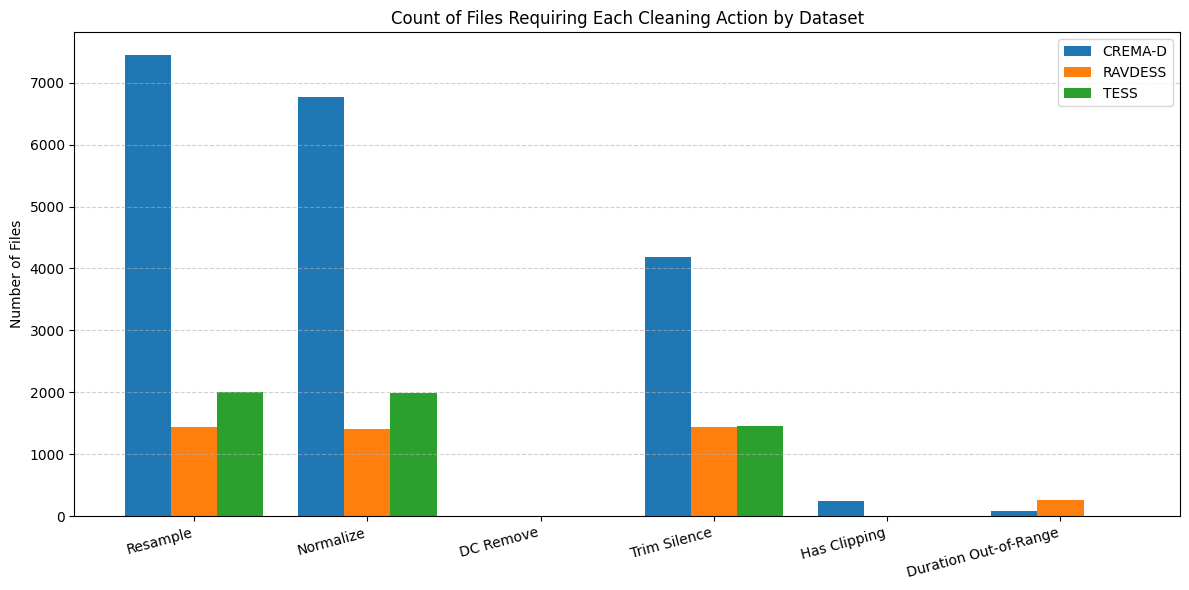

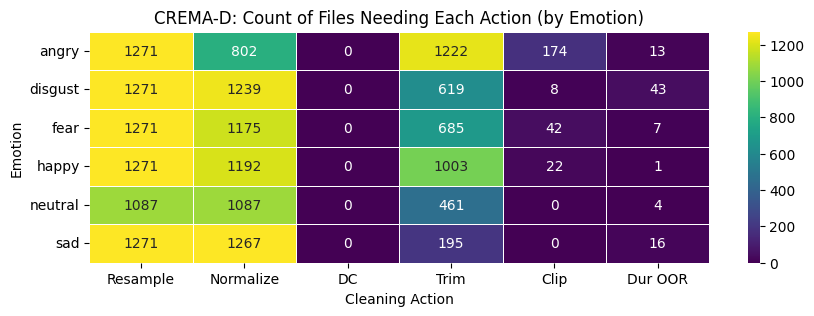

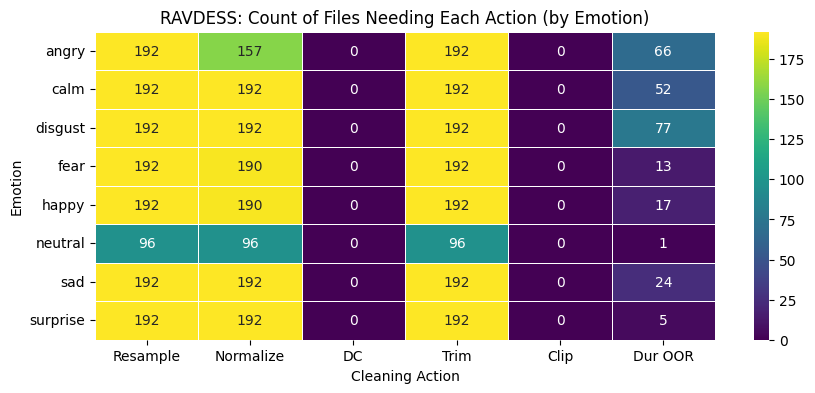

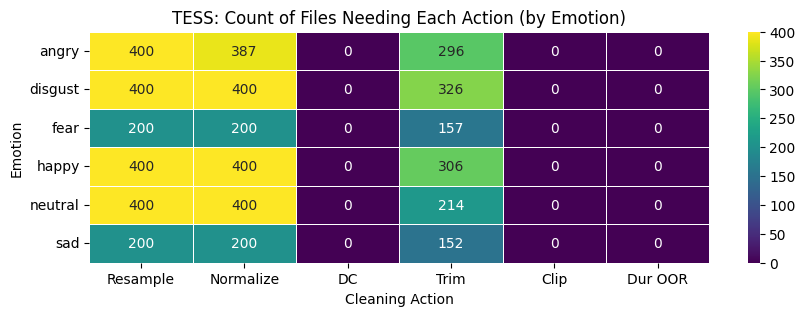

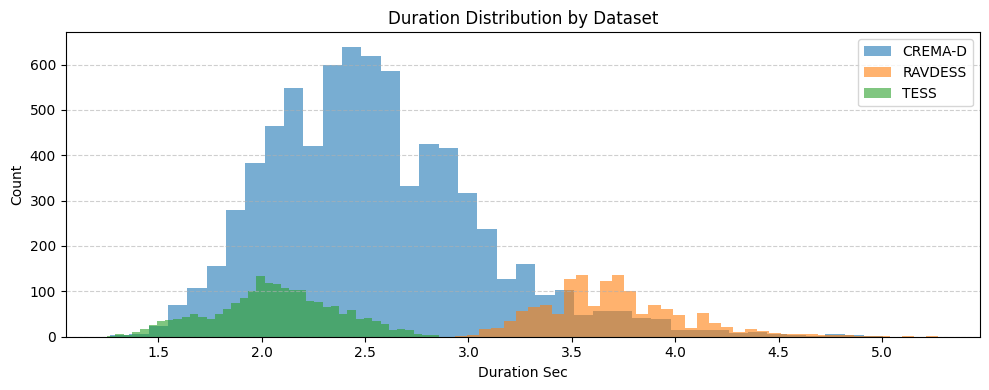

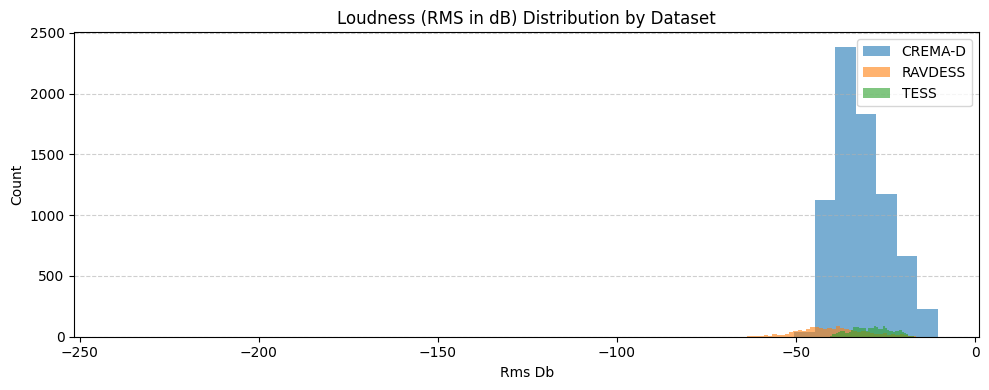

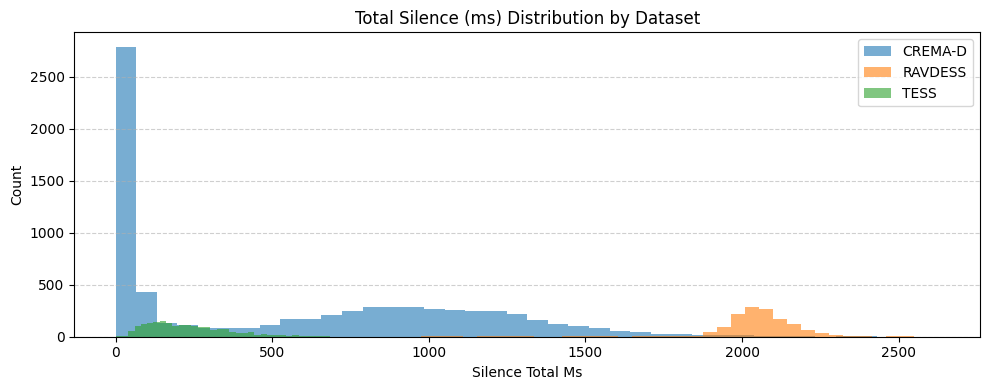

In [ ]:

# Ensure the eda_flags DataFrame from the previous step exists
assert 'eda_flags' in globals(), "Please run the previous cell to build the 'eda_flags' DataFrame first."

# Define the flag columns we want to analyze
flag_cols = [
    "needs_resample",
    "needs_normalize",
    "needs_dc_remove",
    "needs_trim",
    "has_clipping",
    "duration_out_of_range",
]

# ---------- 1) Counts by dataset (table) ----------
print("--- DIAGNOSTICS SUMMARY TABLE ---")
by_dataset = (
    eda_flags.groupby("dataset")[flag_cols]
    .sum()
    .astype(int)
)
total_by_dataset = eda_flags.groupby("dataset")["path"].count().rename("total_files")
summary_table = by_dataset.join(total_by_dataset)
print(summary_table.to_string())


# ---------- 2) Grouped bar chart: Files needing each action (by dataset) ----------
datasets = summary_table.index.tolist()
n_datasets = len(datasets)
x = np.arange(len(flag_cols))
width = 0.8 / n_datasets  # Calculate bar width based on number of datasets

fig, ax = plt.subplots(figsize=(12, 6))

# Loop through datasets to plot bars side-by-side
for i, dataset in enumerate(datasets):
    offset = width * (i - (n_datasets - 1) / 2)
    values = summary_table.loc[dataset, flag_cols].values
    ax.bar(x + offset, values, width, label=dataset)

ax.set_xticks(x)
ax.set_xticklabels([
    "Resample", "Normalize", "DC Remove", "Trim Silence", "Has Clipping", "Duration Out-of-Range"
], rotation=15, ha="right")
ax.set_ylabel("Number of Files")
ax.set_title("Count of Files Requiring Each Cleaning Action by Dataset")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# ---------- 3) Per-emotion heatmap view (counts) ----------
def per_emotion_matrix(df, dataset_name):
    df_ds = df[df["dataset"] == dataset_name]
    # Ensure 'emotion' column exists before grouping
    if 'emotion' not in df_ds.columns:
        print(f"Warning: 'emotion' column not found for {dataset_name}. Skipping heatmap.")
        return None
    mat = (
        df_ds.groupby("emotion")[flag_cols]
        .sum()
        .astype(int)
        .reindex(sorted(df_ds["emotion"].unique()))
    )
    return mat

for ds in summary_table.index:
    mat = per_emotion_matrix(eda_flags, ds)
    if mat is None or mat.empty:
        continue
    plt.figure(figsize=(10, 0.5 * len(mat)))
    sns.heatmap(mat, annot=True, fmt='d', cmap='viridis', linewidths=.5)
    plt.title(f"{ds}: Count of Files Needing Each Action (by Emotion)")
    plt.xlabel("Cleaning Action")
    plt.ylabel("Emotion")
    plt.xticks(ticks=np.arange(len(flag_cols)) + 0.5, labels=["Resample","Normalize","DC","Trim","Clip","Dur OOR"], rotation=0)
    plt.show()


# ---------- 4) Distributions of raw metrics to justify thresholds ----------
def hist_by_dataset(metric, bins=40, title=""):
    fig, ax = plt.subplots(figsize=(10,4))
    for ds, group in eda_flags.groupby("dataset"):
        ax.hist(group[metric].dropna(), bins=bins, alpha=0.6, label=ds)
    ax.set_title(title)
    ax.set_xlabel(metric.replace('_', ' ').title())
    ax.set_ylabel("Count")
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Calculate total silence for a more informative histogram
if "silence_total_ms" not in eda_flags.columns:
    eda_flags["silence_total_ms"] = eda_flags["leading_silence_ms"] + eda_flags["trailing_silence_ms"]

hist_by_dataset("duration_sec", title="Duration Distribution by Dataset")
hist_by_dataset("rms_db",       title="Loudness (RMS in dB) Distribution by Dataset")
hist_by_dataset("silence_total_ms", title="Total Silence (ms) Distribution by Dataset")

**`Full Pipeline - Cleaning, Feature Extraction, and Caching`**<br>
This code creates the final processing pipeline. For each audio file, it will:

Apply Phase 1 (resample, mono, normalize).

Apply Phase 2 (conditionally trim silence).

Convert the clean audio into a log-mel spectrogram (a standard "image" of the sound).

Save the resulting spectrogram to a new cache directory for fast access during model training.

Final features will be saved to: /content/data/speech_emotion_ravdess_tess_crema/features_log_mel

Processing 10882 files. This will create the final features for modeling.


Creating Features:   0%|          | 0/10882 [00:00<?, ?it/s]


--- Feature Extraction Complete ---
Successfully created and cached features for 10882 / 10882 files.

--- Verifying a Sample Feature File ---
Loaded sample feature from: OAF_note_angry.npy
Feature shape: (128, 51) (mel_bins, time_frames)


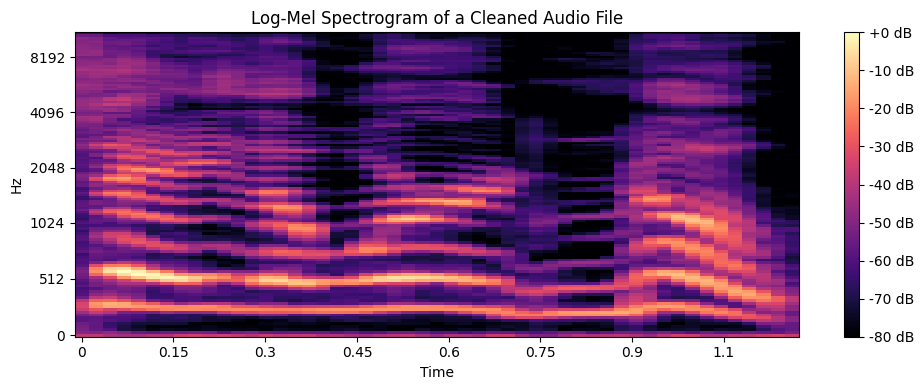

In [ ]:
# --- Configuration ---
TARGET_SR = 22050
TARGET_AMP = 0.95
TRIM_DB = 20

# Librosa feature extraction parameters
N_FFT = 2048
HOP_LENGTH = 512
N_MELS = 128

# --- Feature Cache Directory ---
FEATURES_DIR = os.path.join(LOCAL_ROOT, "features_log_mel")
os.makedirs(FEATURES_DIR, exist_ok=True)
print(f"Final features will be saved to: {FEATURES_DIR}")


# --- All-in-One Processing Function ---

def clean_and_extract_features(row):
    """
    Takes a row from eda_flags, runs the full cleaning pipeline,
    extracts log-mel features, and saves them to a file.
    """
    original_path = row['path']
    needs_trim = row['needs_trim']

    # Define the final path for the cached .npy feature file
    base_name = os.path.basename(original_path).replace('.wav', '.npy')
    feature_path = os.path.join(FEATURES_DIR, base_name)

    # If the feature file already exists, skip processing.
    if os.path.exists(feature_path):
        return feature_path

    try:
        # Phase 1: Minimal Standardization
        y, sr = librosa.load(original_path, sr=TARGET_SR, mono=True)
        y = librosa.util.normalize(y, norm=np.inf) * TARGET_AMP

        # Phase 2: Content-Aware Cleaning (Conditional)
        if needs_trim:
            y, _ = librosa.effects.trim(y, top_db=TRIM_DB)
            # Re-normalize after trimming
            y = librosa.util.normalize(y, norm=np.inf) * TARGET_AMP

        # Step 5: Feature Extraction
        mel_spectrogram = librosa.feature.melspectrogram(
            y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS
        )
        # Convert to decibels (log scale)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Save the final feature array
        np.save(feature_path, log_mel_spectrogram)
        return feature_path

    except Exception as e:
        print(f"Error processing {original_path}: {e}")
        return None

# --- Batch Processing ---
print(f"\nProcessing {len(eda_flags)} files. This will create the final features for modeling.")
tqdm.pandas(desc="Creating Features")
eda_flags['feature_path'] = eda_flags.progress_apply(clean_and_extract_features, axis=1)

print("\n--- Feature Extraction Complete ---")
processed_count = eda_flags['feature_path'].notna().sum()
print(f"Successfully created and cached features for {processed_count} / {len(eda_flags)} files.")

# --- Verification Step ---
print("\n--- Verifying a Sample Feature File ---")
# Load one of the feature files we just created
try:
    sample_feature_path = eda_flags['feature_path'].dropna().iloc[0]
    sample_feature = np.load(sample_feature_path)

    print(f"Loaded sample feature from: {os.path.basename(sample_feature_path)}")
    print(f"Feature shape: {sample_feature.shape} (mel_bins, time_frames)")

    # Display the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(sample_feature, sr=TARGET_SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log-Mel Spectrogram of a Cleaned Audio File')
    plt.tight_layout()
    plt.show()

except (IndexError, NameError):
    print("Could not load a sample feature to display.")

**Creating Speaker-Disjoint Data Splits**

This is one of the most critical steps in building a reliable audio emotion recognition model. <br>

**Why This Step is Crucial**
To ensure that the model is truly learning to identify emotions and not just memorizing the voices of specific speakers, the "speaker-disjoint" (or speaker-independent) splits was created. This means that a single speaker can only appear in one of the sets (training, validation, or testing).

**This script will:**

Extract a unique Speaker ID for every audio file.

Split the list of speakers into train, validation, and test groups.

Create the final dataframes based on this speaker split.

Verify that there is no speaker overlap between the sets.

In [ ]:
# Ensure the eda_flags DataFrame from the previous step exists
assert 'eda_flags' in globals() and 'feature_path' in eda_flags.columns, \
    "Please run the previous cell to create the 'eda_flags' DataFrame."

# --- Step 1: Extract Speaker ID for Each File ---

def get_speaker_id(row):
    """Extracts the speaker ID based on the dataset and file path."""
    dataset = row['dataset']
    path = row['path']

    if dataset == 'RAVDESS':
        # Path: .../RAVDESS/Actor_14/03-01-02-01-02-01-14.wav
        # The folder name 'Actor_14' is a reliable ID.
        match = re.search(r'Actor_(\d+)', path)
        if match:
            return f"ravdess_{match.group(1)}"

    elif dataset == 'TESS':
        # Path: .../TESS/OAF_angry/OAF_back_angry.wav
        # The two speakers are 'OAF' (Older) and 'YAF' (Younger).
        if 'OAF_' in path:
            return 'tess_OAF'
        elif 'YAF_' in path:
            return 'tess_YAF'

    elif dataset == 'CREMA-D':
        # Filename: 1076_MTI_SAD_XX.wav
        # The first part of the filename is the speaker ID.
        filename = os.path.basename(path)
        return f"crema_{filename.split('_')[0]}"

    return None

# Apply the function to create a new 'speaker_id' column
eda_flags['speaker_id'] = eda_flags.apply(get_speaker_id, axis=1)

print("--- Speaker ID Extraction Complete ---")
print("Sample of Speaker IDs:")
print(eda_flags[['dataset', 'speaker_id']].sample(5))


# --- Step 2: Split Speakers into Train, Validation, and Test Sets ---

# Get a unique, sorted list of all speaker IDs
all_speakers = sorted(eda_flags['speaker_id'].unique())
np.random.seed(42) # for reproducibility
np.random.shuffle(all_speakers)

# Define split proportions
train_split = 0.8
val_split = 0.1
# Test split will be the remainder

# Split the list of speakers
train_speakers, val_speakers, test_speakers = np.split(all_speakers, [
    int(len(all_speakers) * train_split),
    int(len(all_speakers) * (train_split + val_split))
])

print(f"\n--- Speaker Split ---")
print(f"Total Speakers: {len(all_speakers)}")
print(f"Training Speakers: {len(train_speakers)}")
print(f"Validation Speakers: {len(val_speakers)}")
print(f"Test Speakers: {len(test_speakers)}")


# --- Step 3: Create Final DataFrames ---

train_df = eda_flags[eda_flags['speaker_id'].isin(train_speakers)].copy()
val_df = eda_flags[eda_flags['speaker_id'].isin(val_speakers)].copy()
test_df = eda_flags[eda_flags['speaker_id'].isin(test_speakers)].copy()

print("\n--- Final DataFrame Sizes ---")
print(f"Training set size:   {len(train_df)} files")
print(f"Validation set size: {len(val_df)} files")
print(f"Test set size:       {len(test_df)} files")


# --- Step 4: Verification ---

# Check for any speaker overlap between sets
train_speaker_set = set(train_df['speaker_id'].unique())
val_speaker_set = set(val_df['speaker_id'].unique())
test_speaker_set = set(test_df['speaker_id'].unique())

assert len(train_speaker_set.intersection(val_speaker_set)) == 0, "Overlap found between train and val speakers!"
assert len(train_speaker_set.intersection(test_speaker_set)) == 0, "Overlap found between train and test speakers!"
assert len(val_speaker_set.intersection(test_speaker_set)) == 0, "Overlap found between val and test speakers!"

print("\n✅ Verification Successful: No speaker overlap found between sets.")


# --- Step 5: Review Emotion Distribution ---

print("\n--- Emotion Distribution in Each Set ---")
print("\nTraining Set:")
print(train_df['emotion'].value_counts().sort_index())
print("\nValidation Set:")
print(val_df['emotion'].value_counts().sort_index())
print("\nTest Set:")
print(test_df['emotion'].value_counts().sort_index())

--- Speaker ID Extraction Complete ---
Sample of Speaker IDs:
      dataset  speaker_id
5256  CREMA-D  crema_1062
2721  RAVDESS  ravdess_13
3424  RAVDESS  ravdess_09
7221  CREMA-D  crema_1062
526      TESS    tess_OAF

--- Speaker Split ---
Total Speakers: 117
Training Speakers: 93
Validation Speakers: 12
Test Speakers: 12

--- Final DataFrame Sizes ---
Training set size:   7951 files
Validation set size: 895 files
Test set size:       2036 files

✅ Verification Successful: No speaker overlap found between sets.

--- Emotion Distribution in Each Set ---

Training Set:
emotion
angry       1383
calm         136
disgust     1383
fear        1183
happy       1383
neutral     1164
sad         1183
surprise     136
Name: count, dtype: int64

Validation Set:
emotion
angry       144
calm         32
disgust     144
fear        144
happy       144
neutral     111
sad         144
surprise     32
Name: count, dtype: int64

Test Set:
emotion
angry       336
calm         24
disgust     336
fear     

--- Visualizing Overall Emotion Distribution ---


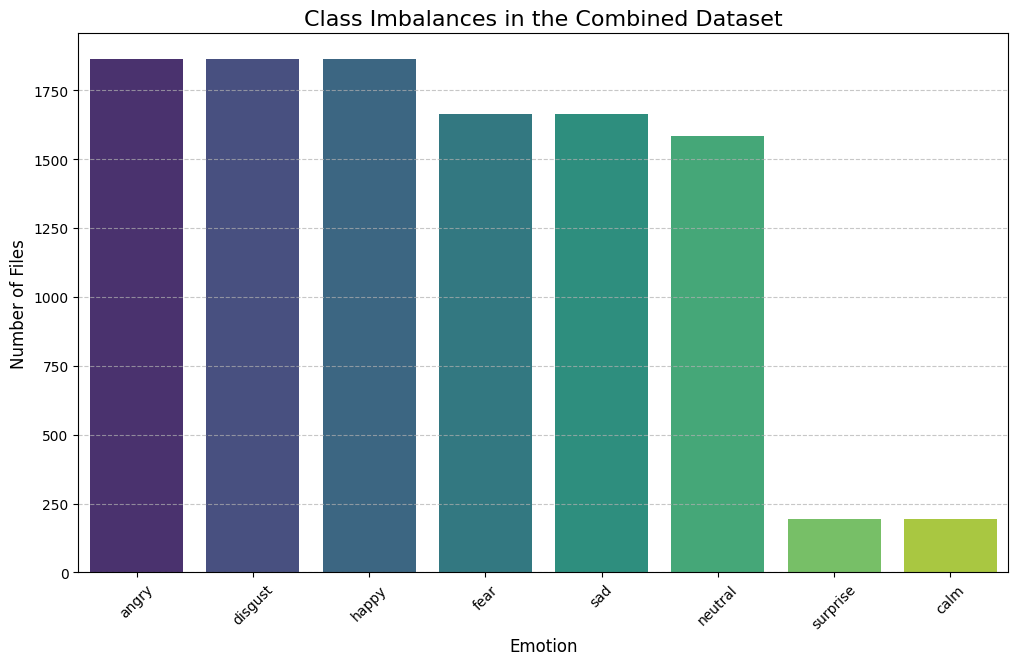

In [ ]:
import seaborn as sns

# Ensure the eda_flags DataFrame from the previous step exists
assert 'eda_flags' in globals(), "Please run the previous cells to create the 'eda_flags' DataFrame."

print("--- Visualizing Overall Emotion Distribution ---")

# Calculate the counts for each emotion in the full dataset
emotion_counts = eda_flags['emotion'].value_counts()

# Create the bar plot
plt.figure(figsize=(12, 7))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette="viridis")

plt.title('Class Imbalances in the Combined Dataset', fontsize=16)
plt.ylabel('Number of Files', fontsize=12)
plt.xlabel('Emotion', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Data Preparation (Part 1): Label Encoding & Finding Target Length
This first block handles the preliminary setup. It encodes your text labels into numbers and then calculates the single, uniform length that all feature vectors will be resized to.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm

# --- Step 1: Encode Emotion Labels ---
# This step converts the string labels ('happy', 'sad') into integers.

# Ensure the DataFrames from the splitting step exist
assert 'train_df' in globals(), "Please run the data splitting cell first."

# We create the encoder and fit it ONLY on the training data to avoid data leakage.
label_encoder = LabelEncoder()
train_df['emotion_encoded'] = label_encoder.fit_transform(train_df['emotion'])
val_df['emotion_encoded'] = label_encoder.transform(val_df['emotion'])
test_df['emotion_encoded'] = label_encoder.transform(test_df['emotion'])

print("--- Label Encoding Complete ---")
# Show the mapping from text to number
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")

# --- Step 2: Pre-calculation to Find a Uniform Feature Length ---
print("\n--- Determining a uniform feature length... ---")
# We'll check the length of every feature to find the median, which is robust to outliers.
all_feature_paths = eda_flags['feature_path'].dropna().tolist()
all_lengths = [np.load(p).shape[1] for p in tqdm(all_feature_paths, desc="Checking feature lengths")]

# This is the target number of time_frames for every spectrogram
TARGET_LEN = int(np.median(all_lengths))
# N_MELS was defined in the feature extraction step (e.g., 128)
UNIFORM_FEATURE_SIZE = TARGET_LEN * N_MELS

print(f"\nTarget number of time frames set to: {TARGET_LEN}")
print(f"All feature vectors will be resized to a uniform size of {UNIFORM_FEATURE_SIZE} features.")

AssertionError: Please run the data splitting cell first.

Data Preparation (Part 2): Loading, Padding & Truncating Features
Now that you have the TARGET_LEN, this second block defines the function that will pad or truncate each spectrogram. It then runs this function on all three of your data splits (train_df, val_df, test_df) to create the final, uniformly-sized X_train, X_val, and X_test arrays.

In [ ]:
# Ensure the TARGET_LEN variable from the previous cell exists
assert 'TARGET_LEN' in globals(), "Please run the previous cell to calculate TARGET_LEN first."

# --- Function to Load, Pad/Truncate, and Flatten Features ---
def load_and_process_features(df, target_len):
    """
    Loads spectrograms, resizes them to a target length, flattens them,
    and returns them as a single numpy array.
    """
    features = []
    for feature_path in tqdm(df['feature_path'], desc="Loading and Resizing Features"):
        spectrogram = np.load(feature_path)

        # Pad or truncate the spectrogram on the time axis (axis=1)
        if spectrogram.shape[1] > target_len:
            spectrogram = spectrogram[:, :target_len] # Truncate
        else:
            padding = target_len - spectrogram.shape[1]
            # Pad with the spectrogram's minimum value (representing silence)
            spectrogram = np.pad(spectrogram, ((0, 0), (0, padding)), mode='constant', constant_values=spectrogram.min())

        features.append(spectrogram.flatten())

    return np.array(features)

# --- Load and Process the Data Splits ---
X_train = load_and_process_features(train_df, TARGET_LEN)
X_val = load_and_process_features(val_df, TARGET_LEN)
X_test = load_and_process_features(test_df, TARGET_LEN)

# Get the corresponding encoded labels from the DataFrames
y_train = train_df['emotion_encoded'].values
y_val = val_df['emotion_encoded'].values
y_test = test_df['emotion_encoded'].values

# --- Verification ---
print("\n--- Data Preparation Complete ---")
print(f"Shape of X_train (features): {X_train.shape}")
print(f"Shape of y_train (labels):   {y_train.shape}")
print(f"\nShape of X_val (features):   {X_val.shape}")
print(f"Shape of y_val (labels):     {y_val.shape}")
print(f"\nShape of X_test (features):  {X_test.shape}")
print(f"Shape of y_test (labels):    {y_test.shape}")

AssertionError: Please run the previous cell to calculate TARGET_LEN first.

Calculating class weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Ensure the train_df DataFrame from the splitting step exists
assert 'train_df' in globals(), "Please run the data splitting cell first to create 'train_df'."

print("--- Calculating Class Weights ---")

# Get the list of unique classes from the training data
class_labels = np.unique(train_df['emotion'])

# Calculate the weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=train_df['emotion']
)


# Create a dictionary mapping the ENCODED INTEGER LABELS (0, 1, 2...) to the weights.
# The label_encoder.transform() correctly converts string labels to their integer representation.
class_weights = dict(zip(label_encoder.transform(class_labels), class_weights_array))

print("Successfully calculated class weights with INTEGER keys:\n")
# We use label_encoder.classes_ to show the original emotion name for readability
for i, label in enumerate(label_encoder.classes_):
    print(f"{label:<10} (label {i}): {class_weights[i]:.4f}")

--- Calculating Class Weights ---
Successfully calculated class weights with INTEGER keys:

angry      (label 0): 0.7186
calm       (label 1): 7.3079
disgust    (label 2): 0.7186
fear       (label 3): 0.8401
happy      (label 4): 0.7186
neutral    (label 5): 0.8538
sad        (label 6): 0.8401
surprise   (label 7): 7.3079


Scaling the Data

In [ ]:
from sklearn.preprocessing import StandardScaler


# Ensure the feature sets (X_train, X_val, X_test) from the previous step exist
assert 'X_train' in globals(), "Please run the previous data preparation cell first."

print("--- Scaling Features ---")

# 1. Initialize the Scaler
scaler = StandardScaler()

# 2. Fit on the training data ONLY and transform it
X_train_scaled = scaler.fit_transform(X_train)

# 3. Transform the validation and test data using the SAME fitted scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# --- Verification Step (with improved formatting) ---
print("Scaling complete.")
print(f"\nOriginal X_train shape: {X_train.shape}")
print(f"Scaled X_train shape:   {X_train_scaled.shape}")

# Create a DataFrame to display the stats in a clean table
verification_data = {
    'Train Mean': np.mean(X_train_scaled[:, :5], axis=0),
    'Train Std Dev': np.std(X_train_scaled[:, :5], axis=0),
    'Test Mean': np.mean(X_test_scaled[:, :5], axis=0),
    'Test Std Dev': np.std(X_test_scaled[:, :5], axis=0),
}
verification_df = pd.DataFrame(
    verification_data,
    index=[f'Feature {i}' for i in range(5)]
)

# Format the numbers in the table for better readability
pd.options.display.float_format = '{:.6f}'.format

print("\n--- Verification of Scaled Features (First 5 Features) ---")
display(verification_df)

# Reset float format to default if you want
# pd.options.display.float_format = None

--- Scaling Features ---
Scaling complete.

Original X_train shape: (7951, 10240)
Scaled X_train shape:   (7951, 10240)

--- Verification of Scaled Features (First 5 Features) ---


,Train Mean,Train Std Dev,Test Mean,Test Std Dev
Feature 0,0.000000,1.000000,-0.530314,0.977422
Feature 1,-0.000000,0.999998,-0.532385,0.961670
Feature 2,0.000000,1.000000,-0.532725,0.954687
Feature 3,0.000000,1.000000,-0.537155,0.964133
Feature 4,0.000000,0.999999,-0.525970,0.980963


In [ ]:

# N_MELS = 128
# TARGET_LEN = 80

# Un-flatten the scaled data back into spectrograms
# Shape: (num_samples, num_mel_bins, num_time_frames)
X_train_reshaped = X_train_scaled.reshape(X_train.shape[0], N_MELS, TARGET_LEN)
X_val_reshaped = X_val_scaled.reshape(X_val.shape[0], N_MELS, TARGET_LEN)
X_test_reshaped = X_test_scaled.reshape(X_test.shape[0], N_MELS, TARGET_LEN)

# The LSTM layer in Keras expects the shape (samples, timesteps, features)
# Our current shape is (samples, features, timesteps)
# So, we need to swap the last two axes
X_train_lstm = np.transpose(X_train_reshaped, (0, 2, 1))
X_val_lstm = np.transpose(X_val_reshaped, (0, 2, 1))
X_test_lstm = np.transpose(X_test_reshaped, (0, 2, 1))


print("--- Data Reshaped for LSTM ---")
print(f"Shape of X_train for LSTM: {X_train_lstm.shape}")
print(f"Shape of X_val for LSTM:   {X_val_lstm.shape}")

--- Data Reshaped for LSTM ---
Shape of X_train for LSTM: (7951, 80, 128)
Shape of X_val for LSTM:   (895, 80, 128)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,872 (550.28 KB)

 Trainable params: 140,616 (549.28 KB)

 Non-trainable params: 256 (1.00 KB)


--- Training the LSTM Model ---
Epoch 1/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.1831 - loss: 2.2413 - val_accuracy: 0.2704 - val_loss: 1.8723 - learning_rate: 0.0010
Epoch 2/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2387 - loss: 1.8260 - val_accuracy: 0.3229 - val_loss: 1.8009 - learning_rate: 0.0010
Epoch 3/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.3075 - loss: 1.5919 - val_accuracy: 0.3318 - val_loss: 1.9200 - learning_rate: 0.0010
Epoch 4/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3337 - loss: 1.4804 - val_accuracy: 0.3587 - val_loss: 1.7855 - learning_rate: 0.0010
Epoch 5/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3888 - loss: 1.3980 - val_accuracy: 0.3687 - val_loss: 1.8312 - learning_rate: 0.0010
Epoch 6/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3897 - loss: 1.3953 - val_accuracy: 0.3609 - val_loss: 1.8205 - learning_rate: 0.0010
Epoch 7/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 9m

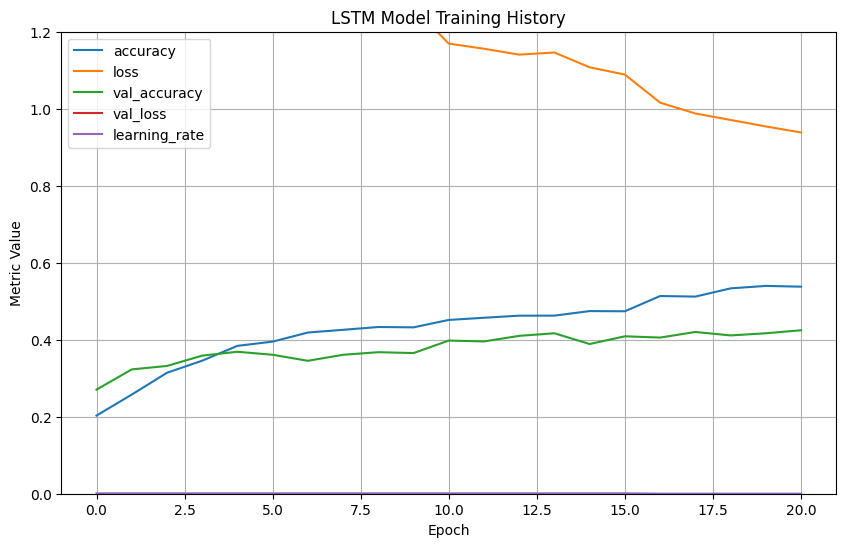

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# --- 1. Define the LSTM Architecture ---
model_lstm = Sequential([
    # The LSTM layer processes the sequence. input_shape is (timesteps, features)
    LSTM(128, input_shape=X_train_lstm.shape[1:], return_sequences=False),
    Dropout(0.4),
    BatchNormalization(),

    # A Dense layer for further processing
    Dense(64, activation='relu'),
    Dropout(0.4),

    # Final output layer
    Dense(len(label_encoder.classes_), activation='softmax')
])

model_lstm.summary()

# --- 2. Compile the Model ---
model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# --- 3. Define Callbacks for Smart Training ---
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# --- 4. Train the LSTM Model ---
print("\n--- Training the LSTM Model ---")
history_lstm = model_lstm.fit(
    X_train_lstm,
    y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=100, # EarlyStopping will find the best number of epochs
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

# --- 5. Plot Training History ---
pd.DataFrame(history_lstm.history).plot(figsize=(10, 6))
plt.grid(True)
plt.gca().set_ylim(0, 1.2)
plt.title("LSTM Model Training History")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.show()

In [ ]:
!pip install -q keras-tuner

import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# --- 1. Create a Model-Building Function ---
def build_lstm_model(hp):
    model = Sequential()

    # Tune the number of units in the LSTM layer
    hp_units = hp.Int('units', min_value=64, max_value=256, step=32)

    # Tune the dropout rate
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)

    # Tune the learning rate for the Adam optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])

    model.add(LSTM(units=hp_units, input_shape=X_train_lstm.shape[1:]))
    model.add(Dropout(rate=hp_dropout))
    model.add(BatchNormalization())

    # --- MODIFIED ---
    # Use integer division (//) to ensure the number of units is an integer
    model.add(Dense(units=hp_units // 2, activation='relu'))
    model.add(Dropout(rate=hp_dropout))

    model.add(Dense(len(label_encoder.classes_), activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# --- 2. Initialize the Tuner ---
tuner = kt.Hyperband(
    build_lstm_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    directory='keras_tuner_dir',
    project_name='speech_emotion_lstm'
)

# --- 3. Run the Hyperparameter Search ---
print("--- Starting Hyperparameter Search for LSTM ---")
stop_early = EarlyStopping(monitor='val_loss', patience=5)

tuner.search(
    X_train_lstm,
    y_train,
    epochs=50,
    validation_data=(X_val_lstm, y_val),
    callbacks=[stop_early],
    class_weight=class_weights
)

# --- 4. Get the Best Hyperparameters and Train the Final Model ---
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
--- Search Complete ---
The optimal number of units in the LSTM layer is {best_hps.get('units')}.
The optimal dropout rate is {best_hps.get('dropout')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Build the model with the best hyperparameters
final_lstm_model = tuner.hypermodel.build(best_hps)

# Train the final, optimized model
print("\n--- Training the Final, Tuned LSTM Model ---")
history_final_lstm = final_lstm_model.fit(
    X_train_lstm,
    y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=100,
    class_weight=class_weights,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Trial 81 Complete [00h 00m 37s]
val_accuracy: 0.37877094745635986

Best val_accuracy So Far: 0.49273744225502014
Total elapsed time: 00h 22m 48s

--- Search Complete ---
The optimal number of units in the LSTM layer is 256.
The optimal dropout rate is 0.30000000000000004.
The optimal learning rate for the optimizer is 0.001.


--- Training the Final, Tuned LSTM Model ---
Epoch 1/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2054 - loss: 2.1069 - val_accuracy: 0.3184 - val_loss: 1.7512
Epoch 2/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3216 - loss: 1.5926 - val_accuracy: 0.2983 - val_loss: 1.8581
Epoch 3/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3760 - loss: 1.4233 - val_accuracy: 0.3240 - val_loss: 1.8691
Epoch 4/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4057 - loss: 1.3205 - val_accuracy: 0.3642 - val_loss: 1.8575
Epoch 5/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4290 - loss: 1.2439 - val_accuracy: 0.37

In [ ]:
import tensorflow as tf
import os

# Ensure the final tuned model from the KerasTuner step exists
assert 'final_lstm_model' in globals(), "Please run the KerasTuner cell to train the final model first."

# --- Define the path to save the model ---
MODELS_DIR = "/content/data/speech_emotion_ravdess_tess_crema/models"
os.makedirs(MODELS_DIR, exist_ok=True)
model_path = os.path.join(MODELS_DIR, "LSTM_Tuned.keras")

# --- Save the model ---
print(f"Saving the tuned LSTM model to: {model_path}")
final_lstm_model.save(model_path)
print("✅ Model saved successfully.")

Saving the tuned LSTM model to: /content/data/speech_emotion_ravdess_tess_crema/models/LSTM_Tuned.keras
✅ Model saved successfully.


 Build and Train the CNN Model